## CNN-SVM

CNN is very good for feature extraction but not very good for classification. SVM is the state of the art algorithm for binary classification. Combining both of them achieves best of both worlds.  

There are two ways of implementing CNN-SVM.

(1) The hinge loss with regularization term forms the complete SVM loss function which gives CNN_SVM implementation.

(2) Train the CNN model as usual and build SVM model using the output of second last layer of CNN model as an input. 

### Importing Required Libraries and Data

In [62]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time
import os
os.chdir("C:/Data/aircraft/")

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.svm import SVC

#for deep learning
import keras
import keras.backend as k
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Activation, Masking, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import RMSprop,adam
from keras.regularizers import l2
from keras.callbacks import History
from keras import callbacks

In [2]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index + 1
    
    return df_train, df_test, y_true

In [3]:
df_train, df_test, y_true = prepare_data(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape

((20631, 18), (13096, 17), (100, 2))

In [4]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [5]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [6]:
df_train['failure'] = [1 if i < 50 else 0 for i in df_train.RUL]
y_true['failure'] = [1 if i < 50 else 0 for i in y_true.RUL]

In [7]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL,failure
0,1,1,-0.080460,-0.666667,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.272028,-0.333333,0.426357,0.449323,191,0
1,1,2,0.218391,-0.500000,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.177376,-0.333333,0.333333,0.462027,190,0
2,1,3,-0.494253,0.500000,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.285110,-0.666667,0.255814,0.242751,189,0
3,1,4,0.080460,0.000000,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.666795,-0.333333,0.147287,0.324772,188,0
4,1,5,-0.218391,-0.333333,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.195845,-0.166667,0.178295,0.409003,187,0


In [8]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.398230,-0.666667,0.317829,0.432753


In [9]:
y_true.head()

,RUL,UnitNumber,failure
0,112,1,0
1,98,2,0
2,69,3,0
3,82,4,0
4,91,5,0



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [10]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [11]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [12]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)


Let's define look back period and mask_value

In [13]:
sequence_length = 50 #predicting using last 30 cycle values
mask_value = 0


Let's prepare data using above functions.

In [14]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 15)


In [15]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "failure")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [16]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [17]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [18]:
nb_features = x_train.shape[2]
nb_out = 1

In [19]:
nb_features

15

In [20]:
class_0 = pd.Series(y_train).value_counts()[0]
class_1 = pd.Series(y_train).value_counts()[1]
total = class_0 + class_1

cls_wt = {0: class_1/total, 1: class_0/total}

In [21]:
cls_wt

{0: 0.3178437480134766, 1: 0.6821562519865234}

### Function to Print results

In [22]:
def print_results(y_test, y_pred):
    
    #f1-score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_true.failure, y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    #roc_auc_score
    model_roc_auc = roc_auc_score(y_test, y_pred) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(y_test, y_pred)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    threshold = np.round(thresholds[ix],3)

    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

### Approach 1

In [102]:
history1 = History()

model1 = Sequential()
model1.add(Conv1D(16, 3, activation = 'relu', input_shape=(sequence_length, nb_features)))
model1.add(Conv1D(16, 3, activation = 'relu'))
model1.add(MaxPooling1D(3))
model1.add(Conv1D(32, 3, activation = 'relu'))
model1.add(Conv1D(32, 3, activation = 'relu'))
model1.add(GlobalAveragePooling1D())
model1.add(Dropout(0.5))
model1.add(Dense(2, kernel_regularizer=l2(0.001)))
model1.add(Activation('softmax'))

model1.compile(loss="hinge", optimizer="adam", metrics=['accuracy'])

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_65 (Conv1D)           (None, 48, 16)            736       
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 46, 16)            784       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 15, 16)            0         
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 13, 32)            1568      
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 11, 32)            3104      
_________________________________________________________________
global_average_pooling1d_14  (None, 32)                0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
__________

Converting labels in proper shape

In [103]:
def get_one_hot(targets, classes):
    res = np.eye(classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape) + [classes])

In [104]:
y_train_2 = get_one_hot(y_train, 2)
y_test_2 = get_one_hot(y_true.failure,2)

In [105]:
y_train_2

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [106]:
y_train_2.shape, y_test_2.shape

((15731, 2), (100, 2))

Fitting the model

In [107]:
%%time
# fit the model
model1.fit(x_train, y_train_2, epochs=100, batch_size=64, validation_split=0.1, verbose=1,
          callbacks = [history1,
                      keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Train on 14157 samples, validate on 1574 samples
Epoch 1/100
14157/14157 [==============================] - 9s 612us/step - loss: 0.5945 - acc: 0.8328 - val_loss: 0.5613 - val_acc: 0.8844
Epoch 2/100
14157/14157 [==============================] - 5s 373us/step - loss: 0.5578 - acc: 0.8929 - val_loss: 0.5562 - val_acc: 0.8914A: 0s - loss: 0.5
Epoch 3/100
14157/14157 [==============================] - 5s 381us/step - loss: 0.5526 - acc: 0.9022 - val_loss: 0.5642 - val_acc: 0.8748
Epoch 4/100
14157/14157 [==============================] - 6s 408us/step - loss: 0.5516 - acc: 0.9029 - val_loss: 0.5658 - val_acc: 0.8717
Epoch 5/100
14157/14157 [==============================] - 6s 399us/step - loss: 0.5497 - acc: 0.9073 - val_loss: 0.5596 - val_acc: 0.8837
Epoch 6/100
14157/14157 [==============================] - 5s 368us/step - loss: 0.5479 - acc: 0.9099 - val_loss: 0.5497 - val_acc: 0.9060
Epoch 7/100
14157/14157 [==============================] - 5s 334us/step - loss: 0.5445 - acc: 0.916

Text(0.5, 1.0, 'Loss')

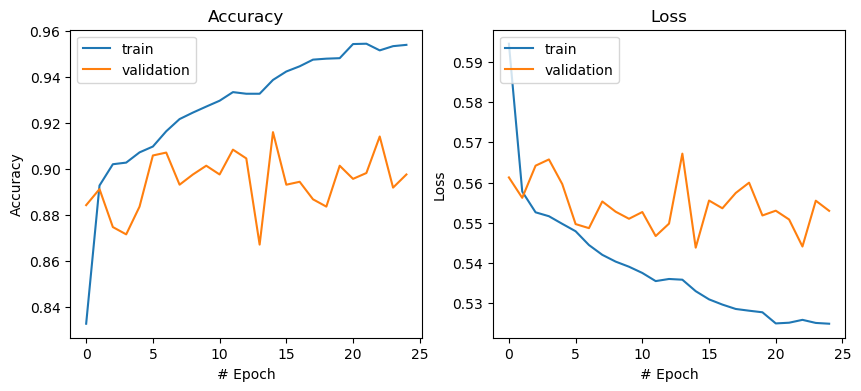

In [108]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history1.history['acc'])
ax[0].plot(history1.history['val_acc'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history1.history['loss'])
ax[1].plot(history1.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

F1 Score:  0.8571428571428572
              precision    recall  f1-score   support

           0       0.96      0.91      0.93        70
           1       0.82      0.90      0.86        30

    accuracy                           0.91       100
   macro avg       0.89      0.91      0.90       100
weighted avg       0.91      0.91      0.91       100

Area under curve :  0.9071428571428571 



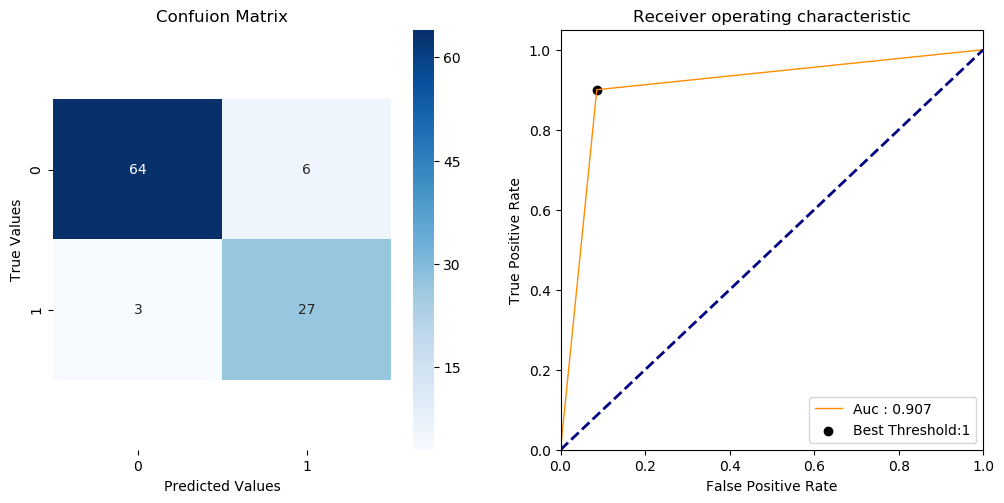

In [109]:
y_pred = model1.predict_classes(x_test)

print_results(y_true.failure, y_pred)

In [110]:
confusion_matrix(y_train, model1.predict_classes(x_train))

array([[10416,   315],
       [  442,  4558]], dtype=int64)

### Approach 2

In [57]:
history2 = History()

model2 = Sequential()
model2.add(Conv1D(16, 3, activation = 'relu', input_shape=(sequence_length, nb_features)))
model2.add(Conv1D(16, 3, activation = 'relu'))
model2.add(MaxPooling1D(3))
model2.add(Conv1D(32, 3, activation = 'relu'))
model2.add(Conv1D(32, 3, activation = 'relu'))
model2.add(GlobalAveragePooling1D(name = 'feature_layer'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 48, 16)            736       
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 46, 16)            784       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 15, 16)            0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 13, 32)            1568      
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 11, 32)            3104      
_________________________________________________________________
feature_layer (GlobalAverage (None, 32)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
__________

In [58]:
%%time
# fit the model
model2.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1,
          callbacks = [history2,
                      keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Train on 14157 samples, validate on 1574 samples
Epoch 1/100
14157/14157 [==============================] - 8s 556us/step - loss: 0.3695 - acc: 0.8440 - val_loss: 0.2741 - val_acc: 0.8907
Epoch 2/100
14157/14157 [==============================] - 6s 416us/step - loss: 0.2499 - acc: 0.9075 - val_loss: 0.2384 - val_acc: 0.8920
Epoch 3/100
14157/14157 [==============================] - 5s 357us/step - loss: 0.1870 - acc: 0.9345 - val_loss: 0.2189 - val_acc: 0.9028
Epoch 4/100
14157/14157 [==============================] - 6s 425us/step - loss: 0.1509 - acc: 0.9436 - val_loss: 0.1513 - val_acc: 0.9371
Epoch 5/100
14157/14157 [==============================] - 5s 378us/step - loss: 0.1294 - acc: 0.9535 - val_loss: 0.1576 - val_acc: 0.9333
Epoch 6/100
14157/14157 [==============================] - 5s 359us/step - loss: 0.1164 - acc: 0.9569 - val_loss: 0.1772 - val_acc: 0.9219
Epoch 7/100
14157/14157 [==============================] - 6s 417us/step - loss: 0.1153 - acc: 0.9568 - val_loss: 0.2

In [61]:
layer_name = 'feature_layer'
intermediate_layer_model = Model(inputs = model2.input,
                                outputs = model2.get_layer(layer_name).output)
cnn_x_train = intermediate_layer_model.predict(x_train)
cnn_x_test = intermediate_layer_model.predict(x_test)

In [63]:
svc = SVC(kernel='rbf', C=1, gamma='auto', class_weight='balanced')

svc.fit(cnn_x_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [65]:
svc.support_vectors_.shape

(1149, 32)

In [66]:
svc.score(cnn_x_train, y_train)

0.9722204564236221

F1 Score:  0.9090909090909091
              precision    recall  f1-score   support

           0       1.00      0.91      0.96        70
           1       0.83      1.00      0.91        30

    accuracy                           0.94       100
   macro avg       0.92      0.96      0.93       100
weighted avg       0.95      0.94      0.94       100

Area under curve :  0.9571428571428571 



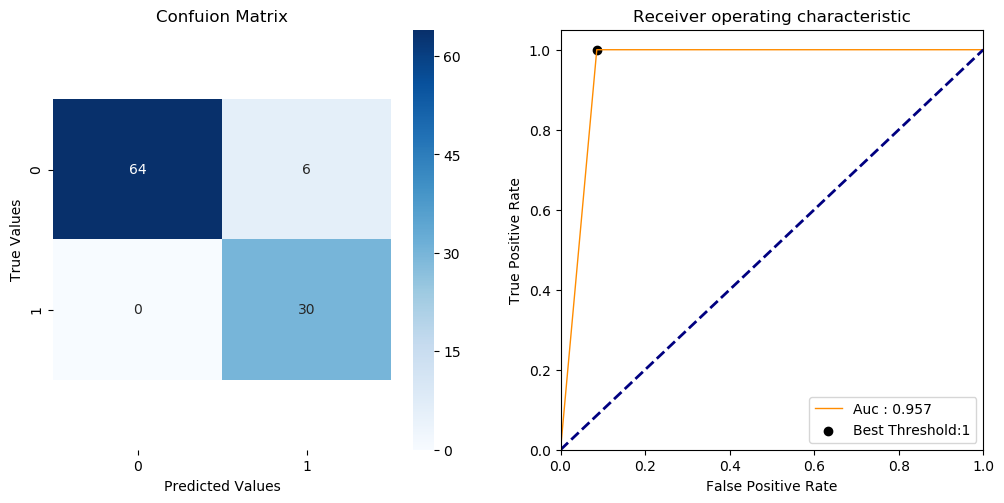

In [68]:
y_pred2 = svc.predict(cnn_x_test)

print_results(y_true.failure, y_pred2)

In [69]:
confusion_matrix(y_train, svc.predict(cnn_x_train))

array([[10406,   325],
       [  112,  4888]], dtype=int64)